In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import albumentations as A
import cv2
import numpy as np
import skimage as ski

import matplotlib.pyplot as plt
import os
import copy

from tqdm import tqdm
from IPython.display import clear_output

import psutil
import pynvml
import sklearn.metrics as metrics

import gc

In [9]:
output_file_path = 'preds_labels.dat'

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)

image_width = 1920
image_height = 1080

target_iters = 300
images_per_iter = 5

kappa_inv = 323

target_sample = image_height * image_width * target_iters * images_per_iter

In [10]:
def read_from_binary_file(file_path):
    dt = np.dtype([('ann_pred', np.float32), ('lr_pred', np.float32), ('label', np.uint32)])
    
    record_size = dt.itemsize

    total_records = os.path.getsize(file_path) // record_size

    quarter_records = total_records // 16

    data = np.memmap(file_path, dtype=dt, mode='r', shape=(quarter_records,))
    
    ann_preds = data['ann_pred']
    lr_preds = data['lr_pred']
    labels = data['label'].astype(int)
    
    return ann_preds, lr_preds, labels

In [11]:
preds_ann, preds_lr, all_labels = read_from_binary_file(output_file_path)

In [12]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
used_memory = total_memory - available_memory
used_memory_gb = used_memory / (1024**3)

print(f"Currently used memory: {used_memory_gb:.2f} GB")

Currently used memory: 20.25 GB


In [13]:
weights = np.empty(preds_ann.shape[0])

weights[all_labels == 1] = 323
weights[all_labels == 0] = 1

In [14]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
used_memory = total_memory - available_memory
used_memory_gb = used_memory / (1024**3)

print(f"Currently used memory: {used_memory_gb:.2f} GB")

Currently used memory: 15.91 GB


In [15]:
precision_ann, recall_ann, pr_thresh_ann = metrics.precision_recall_curve(all_labels, preds_ann, sample_weight=weights)

In [18]:
confs = [0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

map_50_ann = 0
map_50_95_ann = 0

map_50_ann = np.mean(precision_ann[:-1][pr_thresh_ann > 0.5])

for conf in confs:
    map_50_95_ann += (np.mean(precision_ann[:-1][pr_thresh_ann > conf]) / len(confs))

print("ANN:")
print(f"MAP50: {map_50_ann} MAP50-95: {map_50_95_ann}\n")

ANN:
MAP50: 0.9038230187235432 MAP50-95: 0.8509807366767483



In [16]:
f1_score_ann = (2 * precision_ann * recall_ann) / (precision_ann + recall_ann)

/tmp/ipykernel_27673/733668623.py:1: RuntimeWarning: invalid value encountered in divide
  f1_score_ann = (2 * precision_ann * recall_ann) / (precision_ann + recall_ann)


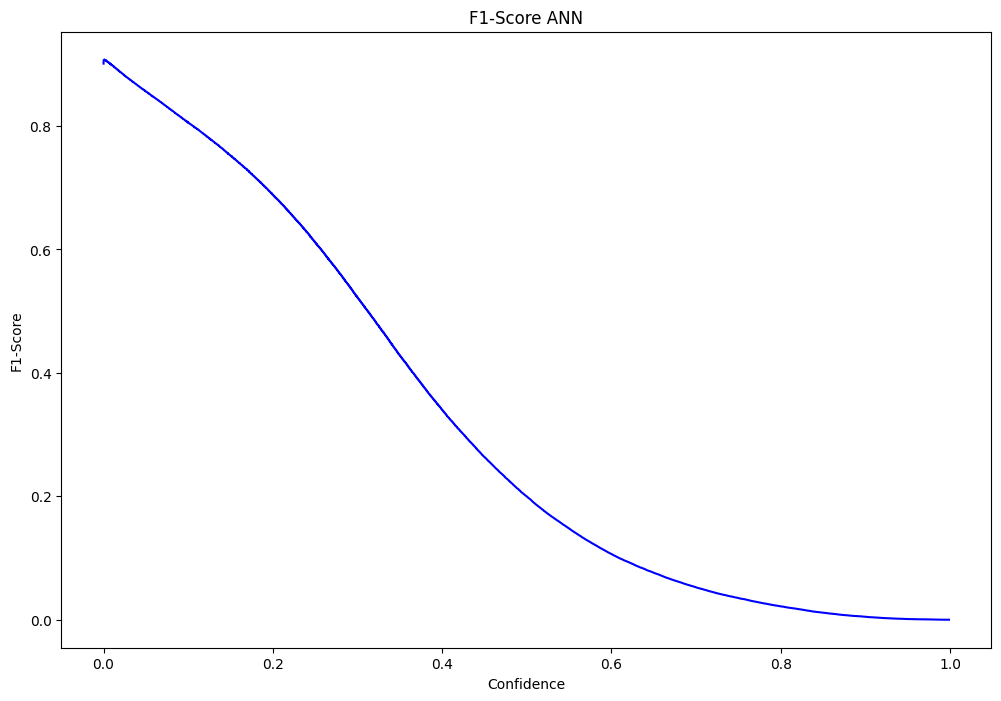

<Figure size 640x480 with 0 Axes>

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(pr_thresh_ann, f1_score_ann[:-1], color='blue')

plt.xlabel('Confidence')
plt.ylabel('F1-Score')
plt.title('F1-Score ANN')
plt.show()

plt.clf()